# Identification of selective sweeps

## Setup

In [2]:
# Load require packages
library(tidyverse)
library(data.table)

── Attaching packages ────────────────────────────────────────────────────────────────────────────────────────────── tidyverse 1.3.0 ──
✔ ggplot2 3.3.3     ✔ purrr   0.3.4
✔ tibble  3.1.2     ✔ dplyr   1.0.6
✔ tidyr   1.1.3     ✔ stringr 1.4.0
✔ readr   1.4.0     ✔ forcats 0.5.1
── Conflicts ───────────────────────────────────────────────────────────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()


In [3]:
# Prefix for results
results_prefix <- '/scratch/projects/trifolium/gwsd/results/'

### Functions

In [38]:
# Function to load windowd thetas 
load_windowed_thetas <- function(path){
    habitat <- str_extract(basename(path), '(?<=allSites_)(\\w+)(?=_windowed)')

    df <- suppressMessages(read_delim(path, delim = '\t')) %>%
        mutate(tp_scaled = tP / nSites,
               habitat = habitat) %>%
        dplyr::select(-tF, -tH, -tL, -fuf, -fud, -fayh, -zeng, -tW, -tP, -starts_with('#'))
    return(df)
}

# Function to load windowed Fst
load_windowed_fst <- function(path){
    chrom <- str_extract(basename(path), '^(.+)(?=_allSites)')
    hab_comb <- str_extract(basename(path), '(?<=allSites_)(\\w+_\\w+)(?=_windowed)')
    
    colnames <- c('region', 'Chr', 'WinCenter', 'nSites_fst', 'fst')
    df <- suppressMessages(read_delim(path, delim = '\t', skip = 1, col_names = colnames)) %>%
        
        # Set negative Fst values to 0
        mutate(fst = ifelse(fst < 0, 0, fst))
    
    return(df)
}

#' Filter dataframe to only include markers in window
#'
#' @param window_start Start position of window
#' @param window_size Size of window in bp
#' @param step Number of base pairs to shift window
#' @param df Dataframe with markers 
#'
#' @return Filtered dataframe containing only markers in windows'
get_windows <- function(window_start, window_size, df){

    df_filt <- df %>%
        arrange(pos) %>%
        filter(pos >= window_start & pos < window_start + window_size) %>%

        # Get min, max, and mid position of window
        mutate(min_pos = window_start,
               max_pos = window_start + window_size,
               mid_pos = window_start + (max_pos - min_pos) / 2)
    return(df_filt)
}

#' Calculate mean cM of markers in window
#' 
#' @param chrom_name Character vector with name of chromosome
#' @param window_size Size of window in bp
#' @param step Number of base pairs to shift window
#' @param df Dataframe with windowed markers
#'
#' @return Dataframe with mean cM in windows
calculate_windowed_means <- function(df, window_size, step, stat, thresh){

    all_pos <- seq(from = min(df$pos), to = max(df$pos), by = step)
    df_withWindows <- purrr::map_dfr(all_pos, get_windows,
                                   df = df,
                                   window_size = window_size,
                                   .id = 'win_id')
    
    df_winMeans <- df_withWindows %>%
        group_by(Chr, win_id, min_pos, max_pos, mid_pos) %>%
        summarise(mean = mean(!!sym(stat)),
                  max = max(!!sym(stat)),
                  min = min(!!sym(stat)),
                  num_gt_thresh = sum(!!sym(stat) > thresh),
                  num_lt_thresh = sum(!!sym(stat) < -thresh),
                  gt_frat = sum(num_gt_thresh) / n(),
                  lt_frat = sum(num_lt_thresh) / n())
    return(df_winMeans)
}

# Function to find outliers. 
find_outliers <- function(df){
    
    # Identify cutoffs of empirical distributions used for definigin outliers
    fst_quant_filt <- quantile(df %>% pull(fst), probs = c(0.99))
    tp_quant_filt <- quantile(df %>% pull(delta_tp_ur), probs = c(0.01, 0.99))
    td_quant_filt <- quantile(df %>% pull(delta_td_ur), probs = c(0.01, 0.99))
    
    outlier_df <- df %>%
    mutate(fst_outlier = ifelse(fst >= fst_quant_filt, 1, 0),
           tp_outlier = ifelse(delta_tp_ur <= tp_quant_filt[1] | delta_tp_ur >= tp_quant_filt[2], 1, 0),
           td_outlier = ifelse(delta_td_ur <= td_quant_filt[1] | delta_td_ur >= td_quant_filt[2], 1, 0),
           all_outlier = ifelse(fst_outlier == 1 & tp_outlier == 1 & td_outlier == 1, 1, 0))
    
    return(outlier_df)
}

## SFS-based tests

- I estimated $\theta_{\pi}$, Tajima's D, and $F_{ST}$ in 5 Kb non-overlapping windows across the genome
- For each window, I will estimate the difference in $\theta_{\pi}$ and Tajima's D between urban and rural habitats (i.e., $\Delta\theta_{\pi}$ and $\Delta$Td)
- I'll define outlier regions as those with:
    1. Lower/Higher $\Delta\theta_{\pi}$ than the genome-wide average
    2. Lower/Higher $\Delta$Td than the genome-wide average
    3. Higher $F_{ST}$ than the genome-wide average

In [133]:
# Load Fst
fst_path <- paste0(results_prefix, 'angsd/summary_stats/hudson_fst/byHabitat/allSites')
fst_df <- list.files(fst_path, recursive = TRUE, full.names = TRUE, pattern = '.+_allSites_Urban_Rural_windowed.fst') %>%
    purrr::map_dfr(., load_windowed_fst) %>%
    mutate(region = paste(Chr, '_', WinCenter))

In [134]:
# Load summary stats (i.e., pi and Tajima's D)
# Currently ignores suburban habitats
thetas_path <- paste0(results_prefix, 'angsd/summary_stats/thetas/byHabitat/allSites')
thetas_df <- list.files(thetas_path, recursive = TRUE, pattern = '.+_allSites_(Rural|Urban)_windowedThetas.gz.pestPG', full.names = TRUE) %>%
    purrr::map_dfr(., load_windowed_thetas)

In [135]:
# Convert to wide format for calculating habitat differences, etc
thetas_df_wide <- thetas_df %>% 
    pivot_wider(values_from = c('Tajima', 'nSites', 'tp_scaled'), names_from = 'habitat') %>%
    mutate(region = paste(Chr, '_', WinCenter))

In [174]:
# Combine windowed theta and fst estimates into single df
# Calculate difference in pi and Tajima's D
total_windows_theta <- nrow(thetas_df_wide)
total_windows_fst <- nrow(fst_df)

allStats_windowed_df <- thetas_df_wide %>%
    filter(region %in% fst_df$region) %>%
    left_join(., fst_df, by = c('region', 'Chr', 'WinCenter')) %>%
    mutate(delta_tp_ur = tp_scaled_Urban - tp_scaled_Rural,
           delta_td_ur = Tajima_Urban - Tajima_Rural) %>%
    dplyr::select(region, everything())

total_windows_allStats <- nrow(allStats_windowed_df)

print(sprintf('There are %s windows with estimates of fst and %s windows with estimates of thetas', total_windows_fst, total_windows_theta))
print(sprintf('%s windows were missing from the Fst Dataframe. %s windows remaining', total_windows_theta - total_windows_allStats, total_windows_allStats))

[1] "There are 161499 windows with estimates of fst and 178473 windows with estimates of thetas"
[1] "16974 windows were missing from the Fst Dataframe. 161499 windows remaining"


In [138]:
testChr_allStats <- allStats_windowed_df %>%
    filter(Chr == 'CM019103.1')

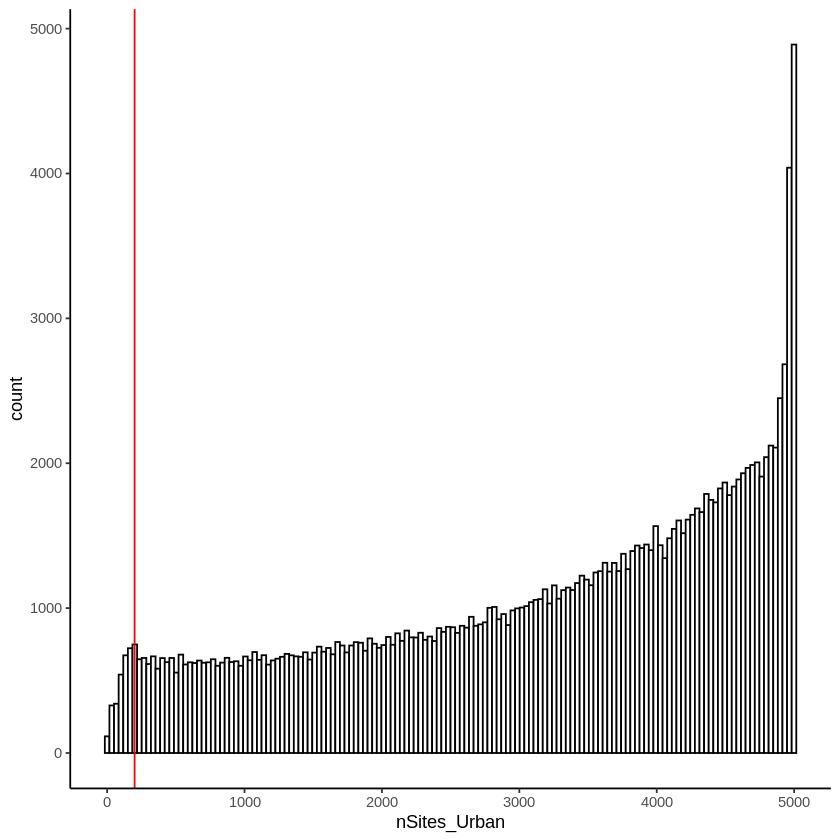

In [144]:
allStats_windowed_df %>% 
    ggplot(., aes(x = nSites_Urban)) +
    geom_histogram(bins = 150, color = 'black', fill = 'white') +
    geom_vline(xintercept = 200, color = 'red') +
    theme_classic()

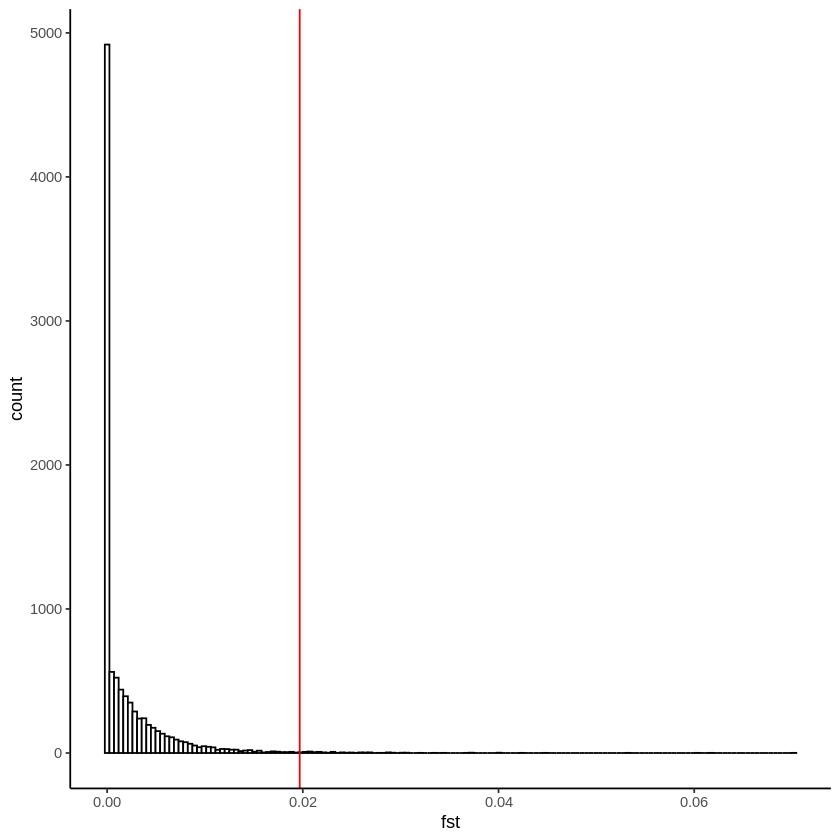

In [173]:
# Quick histogram of the distribution of windowed Fst values
# Red line is 99th percentile
# Use only windows with great than `nSites_thresh`
nSites_thresh <- 200
testChr_allStats_filt <- testChr_allStats %>%
    filter_at(vars(starts_with('nSites')), ~ . >= nSites_thresh)

fst_quant_filt <- quantile(testChr_allStats_filt %>% pull(fst), probs = c(0.99))
tp_quant_filt <- quantile(testChr_allStats_filt %>% pull(delta_tp_ur), probs = c(0.01, 0.99))
td_quant_filt <- quantile(testChr_allStats_filt %>% pull(delta_td_ur), probs = c(0.01, 0.99))

testChr_allStats_filt %>%
    ggplot(., aes(x = fst)) +
    geom_histogram(bins = 150, color = 'black', fill = 'white') +
    geom_vline(xintercept = fst_quant_filt, color = 'red') + 
    theme_classic()

In [146]:
testChr_allStats_filt <- testChr_allStats_filt %>%
    mutate(fst_outlier = ifelse(fst >= fst_quant_filt, 1, 0),
           tp_outlier = ifelse(delta_tp_ur <= tp_quant_filt[1] | delta_tp_ur >= tp_quant_filt[2], 1, 0),
           td_outlier = ifelse(delta_td_ur <= td_quant_filt[1] | delta_td_ur >= td_quant_filt[2], 1, 0),
           all_outlier = ifelse(fst_outlier == 1 & tp_outlier == 1 & td_outlier == 1, 1, 0))

In [147]:
testChr_allStats_filt %>% 
    group_by(fst_outlier, tp_outlier, td_outlier) %>%
    summarise(n = n())

`summarise()` has grouped output by 'fst_outlier', 'tp_outlier'. You can override using the `.groups` argument.


fst_outlier,tp_outlier,td_outlier,n
<dbl>,<dbl>,<dbl>,<int>
0,0,0,9317
0,0,1,129
0,1,0,140
0,1,1,39
1,0,0,67
1,0,1,14
1,1,0,3
1,1,1,14


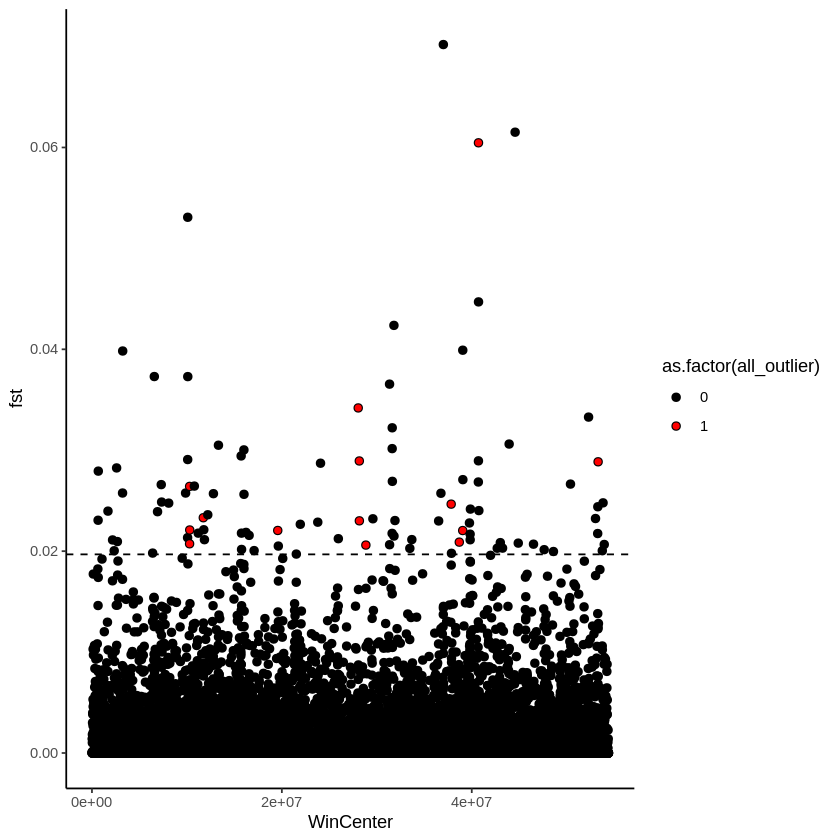

In [149]:
testChr_allStats_filt %>%
    ggplot(., aes(x = WinCenter, y = fst)) +
        geom_point(size = 2, shape = 21, aes(fill = as.factor(all_outlier))) +
        geom_hline(yintercept = fst_quant_filt, color = 'black', size = 0.5, linetype = 'dashed') +
        scale_fill_manual(values = c('black', 'red')) +
        theme_classic()

In [182]:
# Identify outliers across genome
nSites_thresh <- 200
allStats_windowed_filt <- allStats_windowed_df %>%
    filter_at(vars(starts_with('nSites')), ~ . >= nSites_thresh)

fst_quant_filt <- quantile(allStats_windowed_filt %>% pull(fst), probs = c(0.99))
tp_quant_filt <- quantile(allStats_windowed_filt %>% pull(delta_tp_ur), probs = c(0.01, 0.99))
td_quant_filt <- quantile(allStats_windowed_filt %>% pull(delta_td_ur), probs = c(0.01, 0.99))

fst_vals <- allStats_windowed_filt %>% pull(fst)
num_sites <- nrow(fst_quant_filt)

allStats_windowed_filt <- allStats_windowed_filt %>%
mutate(fst_outlier = ifelse(fst >= fst_quant_filt, 1, 0),
       tp_outlier = ifelse(delta_tp_ur <= tp_quant_filt[1] | delta_tp_ur >= tp_quant_filt[2], 1, 0),
       td_outlier = ifelse(delta_td_ur <= td_quant_filt[1] | delta_td_ur >= td_quant_filt[2], 1, 0),
       all_outlier = ifelse(fst_outlier == 1 & tp_outlier == 1 & td_outlier == 1, 1, 0))

In [183]:
head(allStats_windowed_df)

region,Chr,WinCenter,Tajima_Rural,Tajima_Urban,nSites_Rural,nSites_Urban,tp_scaled_Rural,tp_scaled_Urban,nSites_fst,fst,delta_tp_ur,delta_td_ur
<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
CM019101.1 _ 17500,CM019101.1,17500,-0.753305,-0.566911,2196,2185,0.01117766,0.01030627,2154,0.000000,-0.0008713935,0.186394
CM019101.1 _ 22500,CM019101.1,22500,0.305257,0.144632,2852,2896,0.01768361,0.01827413,2649,0.001205,0.0005905253,-0.160625
CM019101.1 _ 27500,CM019101.1,27500,0.690251,0.912409,2519,2754,0.02393400,0.02365930,2437,0.004641,-0.0002746932,0.222158
CM019101.1 _ 32500,CM019101.1,32500,0.029136,0.433021,1907,1978,0.02796054,0.02685587,1565,0.004034,-0.0011046722,0.403885
CM019101.1 _ 42500,CM019101.1,42500,-1.031862,-0.388928,527,465,0.01163581,0.01654779,421,0.000000,0.0049119814,0.642934
CM019101.1 _ 47500,CM019101.1,47500,-0.434842,-0.089310,1589,1501,0.01855840,0.01976798,1405,0.003583,0.0012095745,0.345532


In [184]:
allStats_windowed_filt %>% 
    group_by(fst_outlier, tp_outlier, td_outlier) %>%
    summarise(n = n())

`summarise()` has grouped output by 'fst_outlier', 'tp_outlier'. You can override using the `.groups` argument.


fst_outlier,tp_outlier,td_outlier,n
<dbl>,<dbl>,<dbl>,<int>
0,0,0,151045
0,0,1,2045
0,1,0,2268
0,1,1,665
1,0,0,1077
1,0,1,280
1,1,0,57
1,1,1,162


In [185]:
allStats_windowed_filt %>% 
    filter(all_outlier == 1) %>%
    mutate(direction = ifelse(delta_tp_ur < 0 & delta_td_ur < 0, 'Urban lower', 'Rural lower')) %>%
    group_by(direction) %>%
    summarise(n = n())

direction,n
<chr>,<int>
Rural lower,89
Urban lower,73


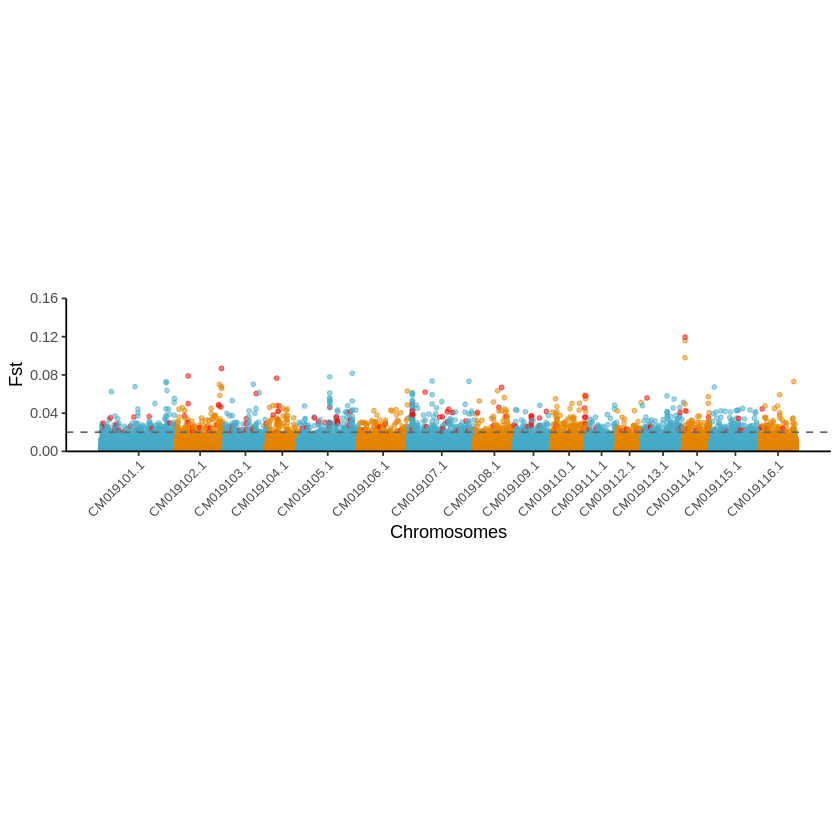

In [186]:
data_cum <- allStats_windowed_filt %>% 
    group_by(Chr) %>% 
    summarise(max_WinCenter = max(WinCenter)) %>% 
    mutate(WinCenter_add = lag(cumsum(max_WinCenter), default = 0)) %>% 
    dplyr::select(Chr, WinCenter_add)

allStats_windowed_filt_mod <- allStats_windowed_filt %>%
    inner_join(data_cum, by = "Chr") %>% 
    mutate(WinCenter_cum = WinCenter + WinCenter_add) 

axis_set <- allStats_windowed_filt_mod %>% 
  group_by(Chr) %>% 
  summarize(center = mean(WinCenter_cum))

outliers <- allStats_windowed_filt_mod %>% filter(all_outlier == 1)

manhat_plot <- allStats_windowed_filt_mod %>%
    mutate(chrom_cat = case_when(Chr == 'CM019101.1' ~ 'One',
                                 Chr == 'CM019102.1' ~ 'Two',
                                 Chr == 'CM019103.1' ~ 'One',
                                 Chr == 'CM019104.1' ~ 'Two',
                                 Chr == 'CM019105.1' ~ 'One',
                                 Chr == 'CM019106.1' ~ 'Two',
                                 Chr == 'CM019107.1' ~ 'One',
                                 Chr == 'CM019108.1' ~ 'Two',
                                 Chr == 'CM019109.1' ~ 'One',
                                 Chr == 'CM019110.1' ~ 'Two',
                                 Chr == 'CM019111.1' ~ 'One',
                                 Chr == 'CM019112.1' ~ 'Two',
                                 Chr == 'CM019113.1' ~ 'One',
                                 Chr == 'CM019114.1' ~ 'Two',
                                 Chr == 'CM019115.1' ~ 'One',
                                 Chr == 'CM019116.1' ~ 'Two')) %>%
    mutate(color_cat = case_when(chrom_cat == 'One' & all_outlier == 0 ~ 'One_NO',
                                 chrom_cat == 'Two' & all_outlier == 0 ~ 'Two_NO',
                                 all_outlier == 1 ~ 'Outlier')) %>% 
    ggplot(aes(x = WinCenter_cum, y = fst)) +
        geom_point(shape = 21, alpha = 0.5, size = 1, aes(fill = color_cat, color = color_cat)) +
        geom_hline(yintercept = fst_quant_filt, color = "grey40", linetype = "dashed") +
        scale_x_continuous(label = axis_set$Chr, breaks = axis_set$center) +
        scale_y_continuous(expand = c(0,0)) +
        coord_cartesian(ylim = c(0, 0.16)) +
        scale_fill_manual(values = c("#46ACC8", "Red", "#E58601")) + 
        scale_color_manual(values = c("#46ACC8", "Red", "#E58601")) + 
        scale_size_manual(values = c(0.5,2)) +
        ylab('Fst') + xlab('Chromosomes') +
        theme_classic() +
        theme(
            aspect.ratio = 0.2,
            legend.position = "none",
            panel.border = element_blank(),
            panel.grid.major.x = element_blank(),
            panel.grid.minor.x = element_blank(),
            axis.text.x = element_text(angle = 45, size = 8,hjust = 1)
          )
manhat_plot

In [187]:
allStats_windowed_filt_mod %>% filter(all_outlier == 1) %>% nrow() / allStats_windowed_filt_mod %>% nrow()

[1] 0.001027925

## XP-nSL

In [4]:
load_xpnsl_norm <- function(path, type){
    
    if(type == 'raw'){
        col_names <- TRUE
    }else{
        col_names <- c('start', 'end', 'num_scores', 'frac_gt', 'frac_lt', 'gt_thresh', 'lt_thresh', 'max', 'min')
    }
    chrom_name <- str_extract(basename(path), pattern = '.+(?=_Urban)')
    df <- suppressMessages(read_delim(path, delim = '\t', col_names = col_names)) %>% 
        mutate(Chr = chrom_name)
    return(df)
    
}

In [5]:
xpnsl_path <- '../../results/sweeps/xpnsl/'
pattern <- '.+_Urban_Rural.xpnsl.out.norm$'
xpnsl_raw_df <- list.files(xpnsl_path, recursive = TRUE, full = TRUE, pattern = pattern) %>% 
    map_dfr(., load_xpnsl_norm, type = 'raw') %>% 
    rename('normxpnsl' = 'normxpehh') %>% 
    dplyr::select(-id)

In [6]:
head(xpnsl_raw_df)

pos,gpos,p1,sL1,p2,sL2,xpnsl,normxpnsl,crit,Chr
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
60409,17,0.768293,6.02195,0.7317070,6.14672,-0.00890653,-0.161338,0,CM019101.1
60426,18,0.256098,5.04439,0.1829270,5.73724,-0.05589440,-0.960627,0,CM019101.1
60431,19,0.182927,5.48507,0.1219510,6.08599,-0.04514880,-0.777839,0,CM019101.1
60443,20,0.000000,6.06068,0.0243902,6.36889,-0.02154270,-0.376287,0,CM019101.1
60463,21,0.170732,5.58482,0.0853659,6.29027,-0.05165990,-0.888596,0,CM019101.1
60479,22,0.817073,6.41365,0.7804880,6.18646,0.01566300,0.256603,0,CM019101.1


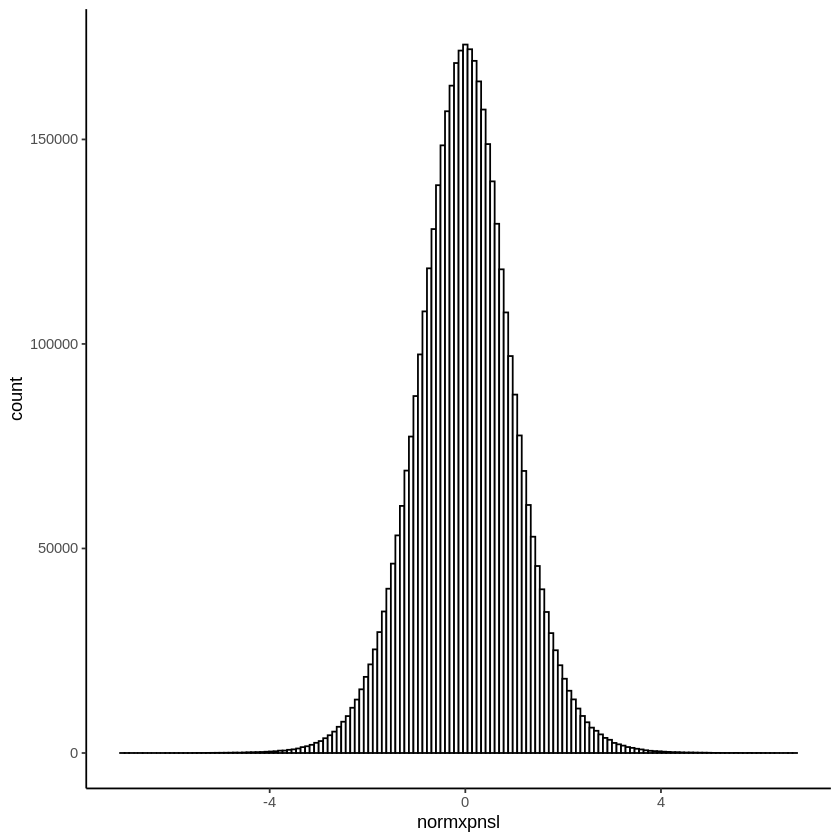

In [7]:
ggplot(xpnsl_raw_df, aes(x = normxpnsl)) +
    geom_histogram(bins = 150, color = 'black', fill = 'white') +
    theme_classic()

In [41]:
window_size <- 50000
step <- 50000
stat <- 'normxpnsl'
thresh <- 2
xpnsl_win_df_cust <- xpnsl_raw_df %>% 
    group_split(Chr) %>% 
    purrr::map_dfr(., calculate_windowed_means, window_size = window_size,
                  step = step, stat = stat, thresh = thresh)

`summarise()` has grouped output by 'Chr', 'win_id', 'min_pos', 'max_pos'. You can override using the `.groups` argument.
`summarise()` has grouped output by 'Chr', 'win_id', 'min_pos', 'max_pos'. You can override using the `.groups` argument.
`summarise()` has grouped output by 'Chr', 'win_id', 'min_pos', 'max_pos'. You can override using the `.groups` argument.
`summarise()` has grouped output by 'Chr', 'win_id', 'min_pos', 'max_pos'. You can override using the `.groups` argument.
`summarise()` has grouped output by 'Chr', 'win_id', 'min_pos', 'max_pos'. You can override using the `.groups` argument.
`summarise()` has grouped output by 'Chr', 'win_id', 'min_pos', 'max_pos'. You can override using the `.groups` argument.
`summarise()` has grouped output by 'Chr', 'win_id', 'min_pos', 'max_pos'. You can override using the `.groups` argument.
`summarise()` has grouped output by 'Chr', 'win_id', 'min_pos', 'max_pos'. You can override using the `.groups` argument.
`summarise()` has groupe

In [49]:
pattern <- '.+_Urban_Rural.xpnsl.out.norm\\..+'
winSize <- 50000
xpnsl_win_df_selscan <- list.files(xpnsl_path, recursive = TRUE, full = TRUE, pattern = pattern) %>% 
    map_dfr(., load_xpnsl_norm, type = 'win') %>% 
    mutate(WinCenter = (start + (winSize / 2)))

In [83]:
xpnsl_outlier_windows <- xpnsl_win_df_selscan %>% filter(gt_thresh == 1 | lt_thresh == 1)

In [166]:
nrow(xpnsl_outlier_windows %>% filter(gt_thresh == 1)) / nrow(xpnsl_win_df_selscan)

[1] 0.01009082

In [88]:
mark_xpnsl_outliers <- function(df_raw_scores, outlier_windows){
    
    gt_windows <- outlier_windows %>% filter(gt_thresh == 1)
    lt_windows <- outlier_windows %>% filter(lt_thresh == 1)

    gt_range <- data.table(start = gt_windows$start, end = gt_windows$end)
    lt_range <- data.table(start = lt_windows$start, end = lt_windows$end)
    
    gt_filt <- setDT(df_raw_scores)[pos %inrange% gt_range]
    lt_filt <- setDT(df_raw_scores)[pos %inrange% lt_range]
    
    df_raw_scores_mod <- df_raw_scores %>% 
        mutate(outlier_cat = case_when(pos %in% gt_filt$pos ~ 'Urban sel',
                                       pos %in% lt_filt$pos ~ 'Rural sel',
                                       TRUE ~ 'Not outlier'))
    
    return(df_raw_scores_mod)
}

In [122]:
df_raw_scores_mod <- xpnsl_raw_df %>% 
    group_split(Chr) %>% 
    purrr::map_dfr(., mark_xpnsl_outliers, outlier_windows = xpnsl_outlier_windows)

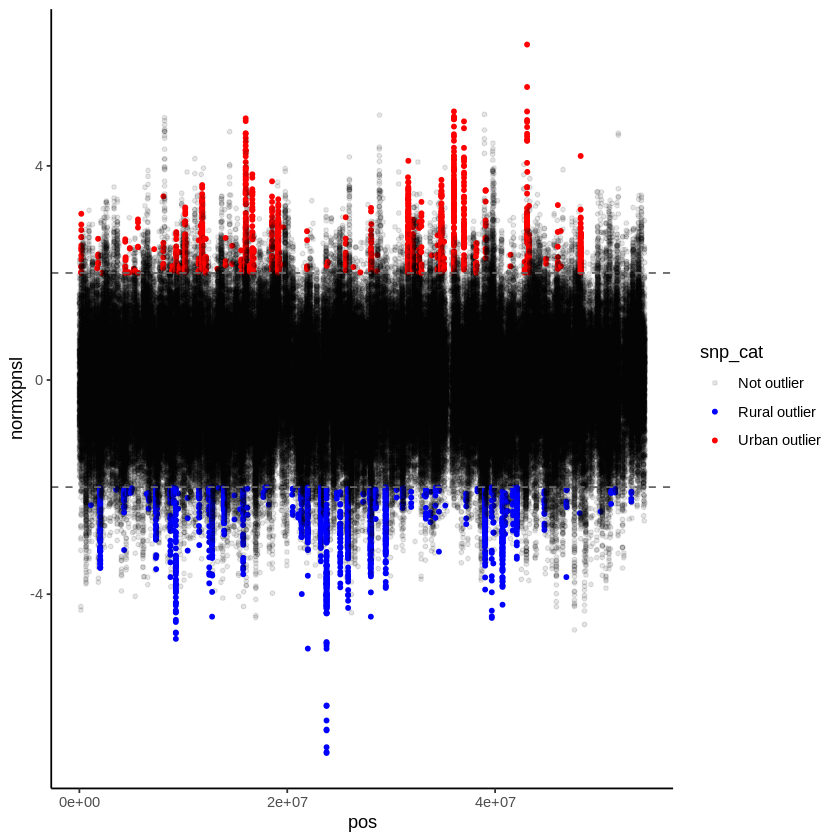

In [163]:
df_raw_scores_mod %>% 
    filter(Chr == 'CM019103.1') %>% 
    mutate(snp_cat = case_when(outlier_cat == 'Urban sel' & crit == 1 ~ 'Urban outlier',
                               outlier_cat == 'Rural sel' & crit == -1 ~ 'Rural outlier',
                               TRUE ~ 'Not outlier')) %>% 
    ggplot(., aes(x = pos, y = normxpnsl)) +
        geom_point(shape = 21, size = 1, aes(alpha = snp_cat, color = snp_cat, fill = snp_cat)) +
        geom_hline(yintercept = 2, color = "grey40", linetype = "dashed") +
        geom_hline(yintercept = -2, color = "grey40", linetype = "dashed") +
        scale_fill_manual(values = c('black', 'blue', 'red')) + 
        scale_color_manual(values = c('black','blue', 'red')) + 
        scale_alpha_manual(values = c(0.1, 1, 1)) +
    theme_classic()

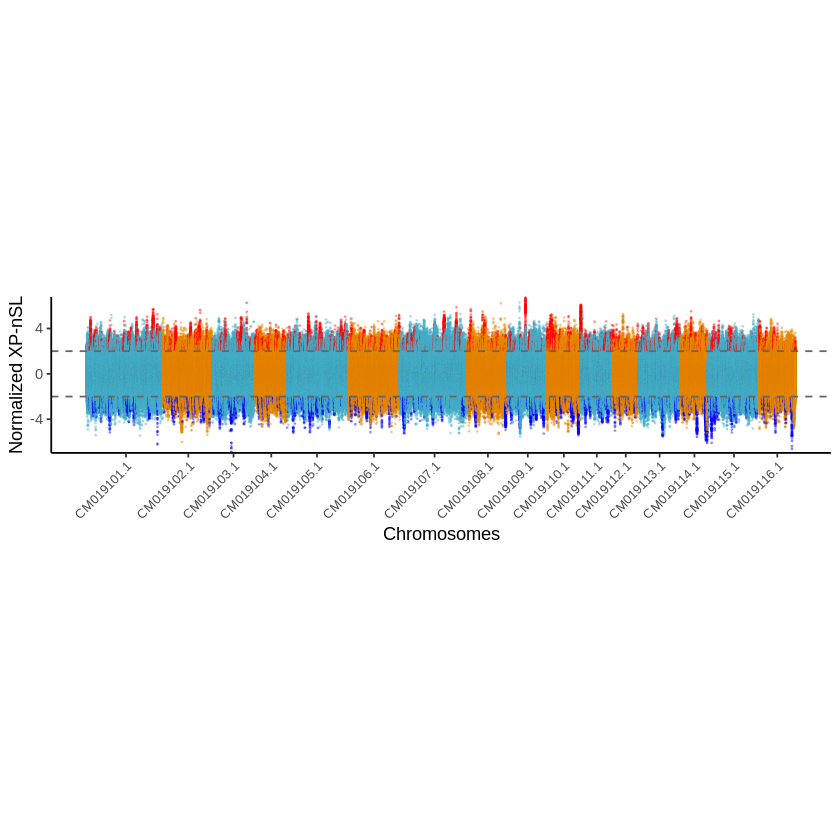

In [132]:
data_cum <- df_raw_scores_mod %>% 
    group_by(Chr) %>% 
    summarise(max_pos = max(pos)) %>% 
    mutate(pos_add = lag(cumsum(max_pos), default = 0)) %>% 
    dplyr::select(Chr, pos_add)

df_raw_scores_mod2 <- df_raw_scores_mod %>%
    inner_join(data_cum, by = "Chr") %>% 
    mutate(pos_cum = pos + pos_add) 

axis_set <- df_raw_scores_mod2 %>% 
  group_by(Chr) %>% 
  summarize(center = mean(pos_cum))

df_raw_scores_mod2 %>%
    mutate(snp_cat = case_when(outlier_cat == 'Urban sel' & crit == 1 ~ 'Urban outlier',
                           outlier_cat == 'Rural sel' & crit == -1 ~ 'Rural outlier',
                           TRUE ~ 'Not outlier')) %>% 
    mutate(chrom_cat = case_when(Chr == 'CM019101.1' ~ 'One',
                                 Chr == 'CM019102.1' ~ 'Two',
                                 Chr == 'CM019103.1' ~ 'One',
                                 Chr == 'CM019104.1' ~ 'Two',
                                 Chr == 'CM019105.1' ~ 'One',
                                 Chr == 'CM019106.1' ~ 'Two',
                                 Chr == 'CM019107.1' ~ 'One',
                                 Chr == 'CM019108.1' ~ 'Two',
                                 Chr == 'CM019109.1' ~ 'One',
                                 Chr == 'CM019110.1' ~ 'Two',
                                 Chr == 'CM019111.1' ~ 'One',
                                 Chr == 'CM019112.1' ~ 'Two',
                                 Chr == 'CM019113.1' ~ 'One',
                                 Chr == 'CM019114.1' ~ 'Two',
                                 Chr == 'CM019115.1' ~ 'One',
                                 Chr == 'CM019116.1' ~ 'Two')) %>%
    mutate(color_cat = case_when(chrom_cat == 'One' & snp_cat == 'Not outlier' ~ 'One_NO',
                                 chrom_cat == 'Two' & snp_cat == 'Not outlier' ~ 'Two_NO',
                                 snp_cat == 'Urban outlier' ~ 'Urban outlier',
                                 snp_cat == 'Rural outlier' ~ 'Rural outlier')) %>% 
    ggplot(aes(x = pos_cum, y = normxpnsl)) +
        geom_point(shape = 21, alpha = 0.3, size = 0.2, aes(fill = color_cat, color = color_cat)) +
        geom_hline(yintercept = 2, color = "grey40", linetype = "dashed") +
        geom_hline(yintercept = -2, color = "grey40", linetype = "dashed") +
        scale_x_continuous(label = axis_set$Chr, breaks = axis_set$center) +
        scale_y_continuous(expand = c(0,0)) +
#         coord_cartesian(ylim = c(0, 0.16)) +
        scale_fill_manual(values = c("#46ACC8", "Blue", "#E58601", "Red")) + 
        scale_color_manual(values = c("#46ACC8", "Blue", "#E58601", "Red")) + 
        ylab('Normalized XP-nSL') + xlab('Chromosomes') +
        theme_classic() +
        theme(
            aspect.ratio = 0.2,
            legend.position = "none",
            panel.border = element_blank(),
            panel.grid.major.x = element_blank(),
            panel.grid.minor.x = element_blank(),
            axis.text.x = element_text(angle = 45, size = 8,hjust = 1)
          )

## Overlap

In [189]:
urban_sel_windows_xpnsl <- xpnsl_outlier_windows %>% filter(gt_thresh == 1)
urban_sel_fst <- allStats_windowed_filt_mod %>% filter(all_outlier == 1)
range <- data.table(start = urban_sel_windows_xpnsl$start, end = urban_sel_windows_xpnsl$end)
outliers_overlappingWIndows <- setDT(urban_sel_fst)[WinCenter %inrange% range]

In [192]:
nrow(outliers_overlappingWIndows) / nrow(urban_sel_fst)

[1] 0.2592593

## Playing around

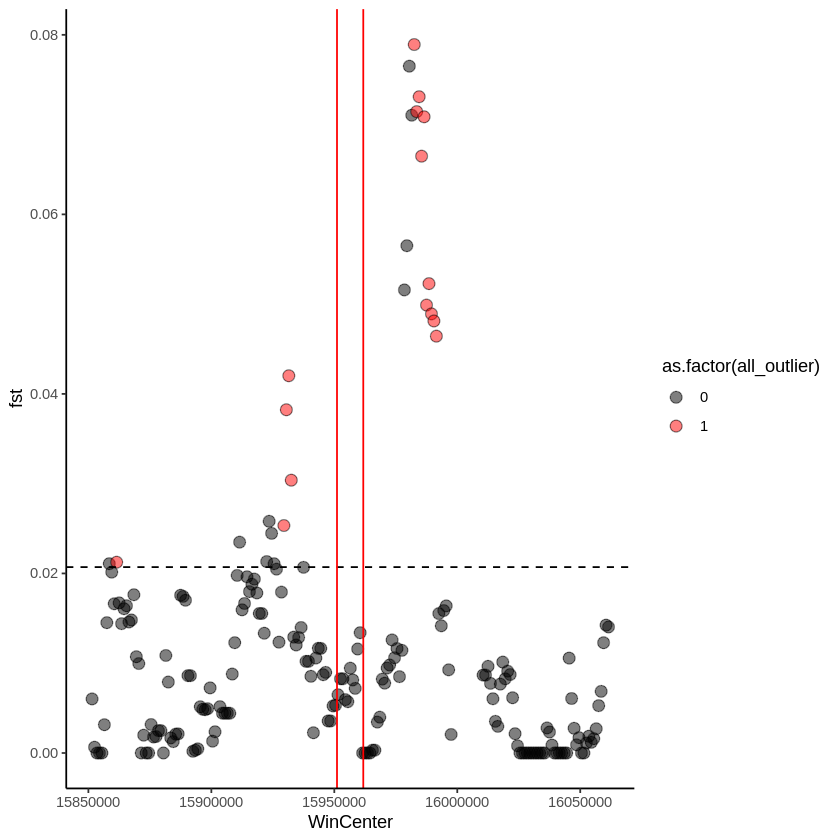

In [22]:
fst_quant <- quantile(testChr_allStats %>% pull(fst), probs = c(0.99))
tp_quant <- quantile(testChr_allStats %>% pull(delta_tp_ur), probs = c(0.01, 0.99))
td_quant <- quantile(testChr_allStats %>% pull(delta_td_ur), probs = c(0.01, 0.99))
Ac_outlier_df <- testChr_allStats %>%
    filter(WinCenter >= 15951095 - 100000 & WinCenter <= 15961779 + 100000) %>%
    mutate(fst_outlier = ifelse(fst >= fst_quant, 1, 0),
           tp_outlier = ifelse(delta_tp_ur <= tp_quant[1] | delta_tp_ur >= tp_quant[2], 1, 0),
           td_outlier = ifelse(delta_td_ur <= td_quant[1] | delta_td_ur >= td_quant[2], 1, 0),
           all_outlier = ifelse(fst_outlier == 1 & tp_outlier == 1 & td_outlier == 1, 1, 0))
Ac_outlier_df %>%
    ggplot(., aes(x = WinCenter, y = fst)) +
        geom_point(size = 3, alpha = 0.5, shape = 21, aes(fill = as.factor(all_outlier))) +
        geom_hline(yintercept = fst_quant, color = 'black', size = 0.5, linetype = 'dashed') +
        scale_fill_manual(values = c('black', 'red')) +
        geom_vline(xintercept = 15951095, color = 'red') +
        geom_vline(xintercept = 15961779, color = 'red') + 
        theme_classic()